# Keypoint Detection on Human Body Silhouette Images




LIU Yipei (s1155128174)

## Introduction

* Detect human body keypoints on silhouette images.
* Deep learning with PyTorch.
* Assignment: **Tune the current side view keypoint detection network and Design a front view keypoint detection network.**
* **All the changes are documented using BOLD font.**


## Data


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
ROOT_FOLDER = './gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment2/'

import glob
print('\nContents in the data folder:')
for x in glob.glob(ROOT_FOLDER+'data/*'):
  print(x)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/

Contents in the data folder:
./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment2/data/train_kpt_front.npy
./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment2/data/train_kpt_side.npy
./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment2/data/README.txt
./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment2/data/test_kpt_side.npy
./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment2/data/test_img_front.npy
./gdrive/My Drive/Co

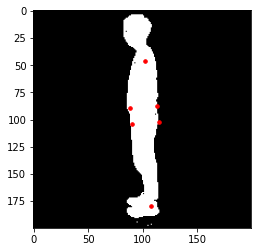

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def draw_points(image, kpts):
    plt.figure()
    plt.imshow(image, cmap='gray')
    keypoints = (kpts+0.5)*IMG_SIZE
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=50, marker='.', c='r')

# load SIDE view data
IMG_SIZE = 200
IMG_S_TRAIN = np.load(ROOT_FOLDER+'data/train_img_side.npy')
IMG_S_TRAIN = np.unpackbits(IMG_S_TRAIN).reshape((-1,IMG_SIZE,IMG_SIZE))
IMG_S_TEST = np.load(ROOT_FOLDER+'data/test_img_side.npy')
IMG_S_TEST = np.unpackbits(IMG_S_TEST).reshape((-1,IMG_SIZE,IMG_SIZE))
KPT_S_TRAIN = np.load(ROOT_FOLDER+'data/train_kpt_side.npy')/IMG_SIZE - 0.5
KPT_S_TEST = np.load(ROOT_FOLDER+'data/test_kpt_side.npy')/IMG_SIZE - 0.5

# show one
idx = 0
draw_points(IMG_S_TRAIN[idx,:,:], KPT_S_TRAIN[idx,:,:])


## PyTorch

PyTorch and Tensorflow are two of the most popular deep learning frameworks. PyTorch is used here.

We need to define
1. Dataset loader
2. Neural network structure
3. Criterion and optimizer

### Dataset loader




**The following data loder can be used for both front and side vies.**

In [0]:
import torch
from torch.utils.data import Dataset

class KeypointsDataset(Dataset):
    '''Keypoints Dataset'''
    def __init__(self, img, kpt, train=True, transform=None):
        self.img = img
        self.kpt = kpt
        self.train = train
        self.transform = transform
    
    def __len__(self):
        return self.img.shape[0]
    
    def __getitem__(self, idx):
        image = self.img[idx,:,:].astype(np.float32)
        if self.train:
            keypoints = self.kpt[idx,:,:].ravel().astype(np.float32)
        else:
            keypoints = None
        sample = {'image': image, 'keypoints': keypoints}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

def prepare_train_valid_loaders(trainset, valid_size=0.2, 
                                batch_size=128):
    '''
    Split trainset data and prepare DataLoader for training and validation
    
    Args:
        trainset (Dataset): data 
        valid_size (float): validation size, defalut=0.2
        batch_size (int) : batch size, default=128
    ''' 
    
    # obtain training indices that will be used for validation
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
    
    return train_loader, valid_loader

In [0]:
from torchvision import transforms
import cv2

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        new_w = np.random.randint(w, self.output_size)
        new_h = new_w
        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))    
        if key_pts is not None:
            return {'image': img, 'keypoints': key_pts}
        else:
            return {'image': img}

class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        if h == new_h:
            return sample
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        #left = top # temp
        image = image[top: top + new_h,
                      left: left + new_w]
        if key_pts is not None:
            #key_pts = key_pts - [left/output_size, top/output_size]
            key_pts[0::2] = ((key_pts[0::2]+0.5)*w-left)/new_w-0.5
            key_pts[1::2] = ((key_pts[1::2]+0.5)*h-top)/new_h-0.5
            return {'image': image, 'keypoints': key_pts}
        else:
            return {'image': image}

class ToTensor(object):
    '''Convert ndarrays in sample to Tensors.'''
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.reshape(1, IMG_SIZE, IMG_SIZE)
        image = torch.from_numpy(image)
        if keypoints is not None:
            keypoints = torch.from_numpy(keypoints)
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image}


**Prepare the data loaders for side view**



In [0]:
batch_size = 32
valid_size = 0.2 # percentage of training set to use as validation

# Define a transform to normalize the data
tsfm_train = transforms.Compose([Rescale(205), RandomCrop(200), ToTensor()])
tsfm_test = transforms.Compose([ToTensor()])

# Load the training data and test data of SIDE view
trainset_side = KeypointsDataset(IMG_S_TRAIN, KPT_S_TRAIN, transform=tsfm_train)
testset_side = KeypointsDataset(IMG_S_TEST, None, train=False, transform=tsfm_test)

# prepare data loaders for side view
train_loader_side, valid_loader_side = prepare_train_valid_loaders(trainset_side, valid_size, batch_size)
test_loader_side = torch.utils.data.DataLoader(testset_side, batch_size=batch_size)

### Neural network structure

In [0]:
from torch import nn, optim
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p =0.5):
        '''
        Buid a forward network with arbitrary hidden layers.
        Arguments
            ---------
            input_size (integer): size of the input layer
            output_size (integer): size of the output layer
            hidden_layers (list of integers):, the sizes of each hidden layers
        '''
        super(MLP, self).__init__()
        # hidden layers
        layer_sizes = [(input_size, hidden_layers[0])] \
                      + list(zip(hidden_layers[:-1], hidden_layers[1:]))
        self.hidden_layers = nn.ModuleList([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        # flatten inputs
        x = x.view(x.shape[0], -1)
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            x = self.dropout(x)
        x = self.output(x)    
        return x

In [0]:
def train(train_loader, valid_loader, model, criterion, optimizer, 
          n_epochs=50, saved_model='model.pt'):
    '''
    Train the model
    
    Args:
        train_loader (DataLoader): DataLoader for train Dataset
        valid_loader (DataLoader): DataLoader for valid Dataset
        model (nn.Module): model to be trained on
        criterion (torch.nn): loss funtion
        optimizer (torch.optim): optimization algorithms
        n_epochs (int): number of epochs to train the model
        saved_model (str): file path for saving model
    
    Return:
        tuple of train_losses, valid_losses
    '''

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to infinity

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*batch['image'].size(0)

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for batch in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # update running validation loss 
            valid_loss += loss.item()*batch['image'].size(0)

        # print training/validation statistics 
        # calculate average Root Mean Square loss over an epoch
        train_loss = np.sqrt(train_loss/len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.sampler.indices))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            model_temp = model.state_dict()
            valid_loss_min = valid_loss
    return train_losses, valid_losses 

### Criterion and optimizer

**Tarin the side view model using MLP**


In [0]:
from torch import optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# output_size ?
# Side view keypoints: 6x2 = 12
# model_side = MLP(input_size=IMG_SIZE*IMG_SIZE, output_size=12, 
#             hidden_layers=[128, 64], drop_p=0.1)
# model_side = model_side.to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adamax(model_side.parameters(), lr=0.0008)

# train_losses, valid_losses = train(train_loader_side, valid_loader_side,
#                   model_side, criterion, optimizer,
#                   n_epochs=350,
#                   saved_model=ROOT_FOLDER+'model_side.pt')

### Evaluation

In [0]:
def predict(data_loader, model):
    '''
    Predict keypoints
    Args:
        data_loader (DataLoader): DataLoader for Dataset
        model (nn.Module): trained model for prediction.
    Return:
        predictions (array-like): keypoints in float (no. of images x keypoints).
    '''
    
    model.eval() # prep model for evaluation

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device)).cpu().numpy()
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))

    return predictions

**Predict and evaluate the keypoints for side view using MLP**

MLP model has been compared with the CNN. **It is shown that CNN works better for this assignment.** However, the tuned MLP model still provides a relatively good prediction compared with the original one. The error is **0.069** with the parameters:


*   Learning rate: 0.0008
*   Optimizer: Adamax
*   Number of epochs: 350
*   Batch size: 32



Error:  0.06900499070011534


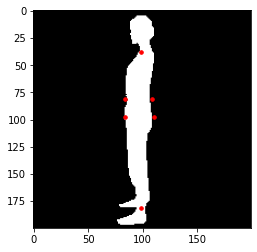

In [0]:
model_side.load_state_dict(torch.load(ROOT_FOLDER+'model_side.pt'))
predictions_side = predict(test_loader_side, model_side)

print('Error: ', np.linalg.norm(predictions_side-KPT_S_TEST.reshape((predictions_side.shape[0],-1)), axis=1).mean())

idx = 88
draw_points(IMG_S_TEST[idx,:,:], predictions_side[idx,:].reshape((-1,2)))

### Try another network

**The structure of the CNN has been changed and the detailed parameters can be found in the following code.**

In [0]:
class CNN(nn.Module):
      def __init__(self, output_size):
        super(CNN, self).__init__()
        # 200 x 20
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        # (w-f)/s+1 = 196
        self.pool1 = nn.MaxPool2d(4, 4)
        # 98
        self.conv2 = nn.Conv2d(32, 64, 3, padding=2)
        # (98-3)/1 + 1 = 96
        self.pool2 = nn.MaxPool2d(2, 2)
        # 48
        self.conv3 = nn.Conv2d(64, 128, 3)
        # (48-3)/1 + 1 = 46
        self.pool3 = nn.MaxPool2d(2, 2)
        # 23
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2)
        # (23-3)/2 + 1 = 11
        self.conv5 = nn.Conv2d(256, 512, 1)
        # (11-1)/2+1 = 6
    
        # Linear Layer
        self.fc1 = nn.Linear(12800, 1024)
        self.fc2 = nn.Linear(1024, output_size)
        self.drop1 = nn.Dropout(p=0.1)
        self.drop2 = nn.Dropout(p=0.25)
        self.drop3 = nn.Dropout(p=0.25)
        self.drop4 = nn.Dropout(p=0.25)
        self.drop5 = nn.Dropout(p=0.35)
        self.drop6 = nn.Dropout(p=0.4)
    
      def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.drop1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.drop2(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.drop3(x)
        x = F.relu(self.conv4(x))
        x = self.drop4(x)
        x = F.relu(self.conv5(x))
        x = self.drop5(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x == self.drop6(x)
        x = self.fc2(x)
        return x


**Train the side view model using CNN**



In [0]:
model_side = CNN(output_size=12)
model_side = model_side.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_side.parameters(), lr=0.0005)

train_losses, valid_losses = train(train_loader_side, valid_loader_side,
                   model_side, criterion, optimizer,
                   n_epochs=150,
                   saved_model=ROOT_FOLDER+'model_side.pt')

Epoch: 1 	Training Loss: 0.059678 	Validation Loss: 0.034137
Validation loss decreased (inf --> 0.034137).  Saving model ...
Epoch: 2 	Training Loss: 0.036047 	Validation Loss: 0.029128
Validation loss decreased (0.034137 --> 0.029128).  Saving model ...
Epoch: 3 	Training Loss: 0.032192 	Validation Loss: 0.028572
Validation loss decreased (0.029128 --> 0.028572).  Saving model ...
Epoch: 4 	Training Loss: 0.031583 	Validation Loss: 0.031889
Epoch: 5 	Training Loss: 0.031062 	Validation Loss: 0.028014
Validation loss decreased (0.028572 --> 0.028014).  Saving model ...
Epoch: 6 	Training Loss: 0.030567 	Validation Loss: 0.028644


**Predict and evaluate the side view using CNN**

The CNN has been compared with the MLP model and it is obvious that CNN provids a better work. So the final network structure is chosen as CNN.

In this CNN model, the hidden layers of the network has been changed to the trend of "Conv->ReLU->Pool->Droput" and such trend has been implemented for four times in this network. At last, three fully connected layers are implemented to get the output.

When tuning this network, it is important to choose the number of filters (i.e. Number of channels) during convolution. It is started by using smaller number of filters to collect as much local information as possible, and then gradually increase it to reduce the generated feature. In order to prevent overfitting, maximum pooling is used after each convolution. It can also reduce the dimension of the data and increase the computing speed. After several trial of different parameters, the overfitting still exists when number of epochs reaching 100. Hence, some dropout layers are added to the network.

Apart from the mentioned tuning criteria used in this network, trial and error is also implemented to find the better parameters such as learning rate and batch size. 

It is shown that the final error is **0.0599**. Hence, this model is better than the original one which has error of 0.0664. Here some parameters are listed:


*   Learning rate: 0.0008
*   Optimizer: Adamax
*   Number of epochs: 350
*   Batch size: 32

The other parameters in the CNN structure can be found the definition of the CNN class.

**And the final prediction error of the side view should be 0.0599.**



Error:  0.059441862324435026
3


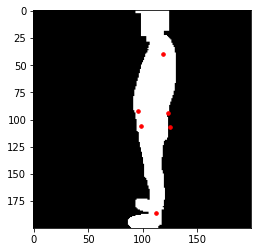

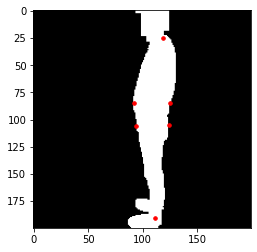

In [47]:
# Evaluate this one
model_side.load_state_dict(torch.load(ROOT_FOLDER+'model_side.pt'))
predictions_side = predict(test_loader_side, model_side)

# baseline: 0.069
print('Error: ', np.linalg.norm(predictions_side-KPT_S_TEST.reshape((predictions_side.shape[0],-1)), axis=1).mean())

#Show one prediction and test result
idx = np.random.randint(predictions_side.shape[0])
print(idx)
draw_points(IMG_S_TEST[idx,:,:], predictions_side[idx,:].reshape((-1,2)))
draw_points(IMG_S_TEST[idx,:,:], KPT_S_TEST[idx,:,:])

(300,)
(300,)
(300,)
[0.05893877614346699, 0.03423917848501631, 0.031426348432160696, 0.03067355191344148, 0.02985524473199222, 0.029761820977790582, 0.031174506421301384, 0.030650480225102163, 0.028875292309213228, 0.02833855561382512, 0.02834736964086926, 0.027427706531403768, 0.026157837566505054, 0.02652180737435617, 0.02620629157863196, 0.025823577944531807, 0.02590838552670305, 0.025810195241734626, 0.025010047114671287, 0.02394418004136619, 0.024635458432202325, 0.02423534930030464, 0.02430390657644392, 0.02390104146020435, 0.024423175779795362, 0.02357666178866544, 0.02405020329550945, 0.023181401658688594, 0.023350263009680735, 0.02327139823499834, 0.022139987426897895, 0.022745675099295377, 0.022243397607308747, 0.022350037679382793, 0.022237623220565234, 0.02154741358965636, 0.02173228361109005, 0.02184864032863562, 0.02070466617255019, 0.021733135926935203, 0.021407997664100897, 0.021627802692045135, 0.021224103933024596, 0.02073820013230961, 0.020044454551853642, 0.0201958

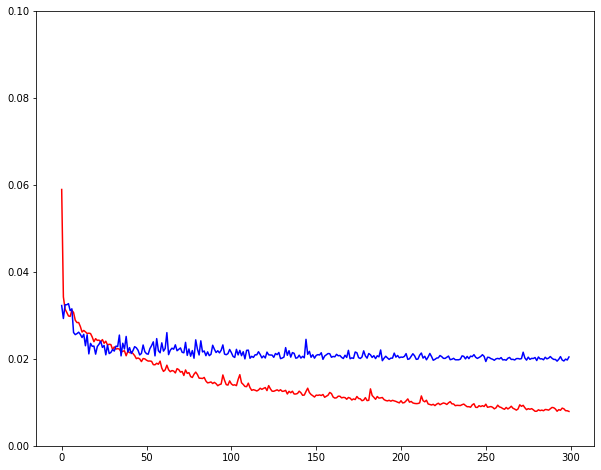

In [41]:
# Draw the curve
n_epochs=300
x=range(0,n_epochs)
plt.figure(figsize=(10,8))
y1=train_losses
y2=valid_losses
print(np.shape(x))
print(np.shape(y1))
print(np.shape(y2))
plt.plot(x,y1,color="red")
plt.plot(x,y2,color="blue")
plt.ylim(0,0.1)
print(y1)

### **Design and train the front view keypoint prediction network**

**Load the data from the folder**

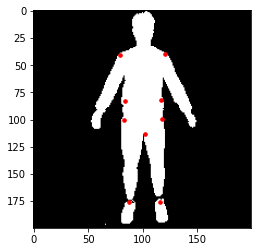

In [0]:
# load FRONT view data
IMG_F_TRAIN = np.load(ROOT_FOLDER+'data/train_img_front.npy')
IMG_F_TRAIN = np.unpackbits(IMG_F_TRAIN).reshape((-1,IMG_SIZE,IMG_SIZE))
IMG_F_TEST = np.load(ROOT_FOLDER+'data/test_img_front.npy')
IMG_F_TEST = np.unpackbits(IMG_F_TEST).reshape((-1,IMG_SIZE,IMG_SIZE))
KPT_F_TRAIN = np.load(ROOT_FOLDER+'data/train_kpt_front.npy')/IMG_SIZE - 0.5

#Show one
idx = 0
draw_points(IMG_F_TRAIN[idx,:,:], KPT_F_TRAIN[idx,:,:])

**Prepare the data loaders for front view**

In [0]:
batch_size = 32
valid_size = 0.2 # percentage of training set to use as validation

# Define a transform to normalize the data
tsfm_train = transforms.Compose([Rescale(205), RandomCrop(200), ToTensor()])
tsfm_test = transforms.Compose([ToTensor()])

# Load the training data and test data of FRONT view
trainset_front = KeypointsDataset(IMG_F_TRAIN, KPT_F_TRAIN, transform=tsfm_train)
testset_front = KeypointsDataset(IMG_F_TEST, None, train=False, transform=tsfm_test)

# prepare data loaders for front view
train_loader_front, valid_loader_front = prepare_train_valid_loaders(trainset_front, valid_size, batch_size)
test_loader_front = torch.utils.data.DataLoader(testset_front, batch_size=batch_size)

**Train the model for the front view using MLP**

In [0]:
# Front view keypoints: 9x2 = 18
model_front = MLP(input_size=IMG_SIZE*IMG_SIZE, output_size=18, 
            hidden_layers=[128, 64], drop_p=0.1)
model_front = model_front.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adamax(model_front.parameters(), lr=0.0008)

train_losses, valid_losses = train(train_loader_front, valid_loader_front,
                  model_front, criterion, optimizer,
                  n_epochs=350,
                  saved_model=ROOT_FOLDER+'model_front.pt')

Epoch: 1 	Training Loss: 0.399470 	Validation Loss: 0.142524
Validation loss decreased (inf --> 0.142524).  Saving model ...
Epoch: 2 	Training Loss: 0.149086 	Validation Loss: 0.116880
Validation loss decreased (0.142524 --> 0.116880).  Saving model ...
Epoch: 3 	Training Loss: 0.127861 	Validation Loss: 0.088553
Validation loss decreased (0.116880 --> 0.088553).  Saving model ...
Epoch: 4 	Training Loss: 0.110293 	Validation Loss: 0.066396
Validation loss decreased (0.088553 --> 0.066396).  Saving model ...
Epoch: 5 	Training Loss: 0.097753 	Validation Loss: 0.056937
Validation loss decreased (0.066396 --> 0.056937).  Saving model ...
Epoch: 6 	Training Loss: 0.087003 	Validation Loss: 0.049587
Validation loss decreased (0.056937 --> 0.049587).  Saving model ...
Epoch: 7 	Training Loss: 0.081128 	Validation Loss: 0.045513
Validation loss decreased (0.049587 --> 0.045513).  Saving model ...
Epoch: 8 	Training Loss: 0.073663 	Validation Loss: 0.041203
Validation loss decreased (0.04551

**Predict and evaluate the keypoints for front view using MLP**

MLP model cannot provide a satisfying prediction and CNN will be used.

104


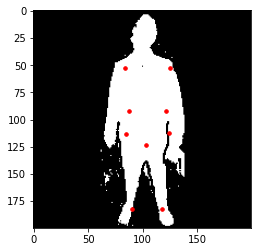

In [0]:
model_front.load_state_dict(torch.load(ROOT_FOLDER+'model_front.pt'))
predictions_front = predict(test_loader_front, model_front)

idx = np.random.randint(predictions_front.shape[0])
print(idx)
draw_points(IMG_F_TEST[idx,:,:], predictions_front[idx,:].reshape((-1,2)))

**Train the model for the front view using CNN**



In [0]:
model_front = CNN(output_size=18)
model_front = model_front.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adamax(model_front.parameters(), lr=0.0008)

train_losses, valid_losses = train(train_loader_front, valid_loader_front,
                   model_front, criterion, optimizer,
                   n_epochs=350,
                   saved_model=ROOT_FOLDER+'model_front.pt')

Epoch: 1 	Training Loss: 0.134654 	Validation Loss: 0.080337
Validation loss decreased (inf --> 0.080337).  Saving model ...
Epoch: 2 	Training Loss: 0.071912 	Validation Loss: 0.088522
Epoch: 3 	Training Loss: 0.063310 	Validation Loss: 0.083203
Epoch: 4 	Training Loss: 0.057920 	Validation Loss: 0.080268
Validation loss decreased (0.080337 --> 0.080268).  Saving model ...
Epoch: 5 	Training Loss: 0.054086 	Validation Loss: 0.076902
Validation loss decreased (0.080268 --> 0.076902).  Saving model ...
Epoch: 6 	Training Loss: 0.052070 	Validation Loss: 0.072719
Validation loss decreased (0.076902 --> 0.072719).  Saving model ...
Epoch: 7 	Training Loss: 0.050358 	Validation Loss: 0.071061
Validation loss decreased (0.072719 --> 0.071061).  Saving model ...
Epoch: 8 	Training Loss: 0.047981 	Validation Loss: 0.072220
Epoch: 9 	Training Loss: 0.046963 	Validation Loss: 0.068796
Validation loss decreased (0.071061 --> 0.068796).  Saving model ...
Epoch: 10 	Training Loss: 0.045600 	Valida

**Predict and evaluate the front view using CNN**

Just as the prediction of the side view, CNN performs better than MLP in predicting front view keypoints. The structure of this network is based on the one that is used on the side view. 

It can be seen that the training loss and the validation loss are pretty close and the validation loss is 0.0159 which is relatively low. Additionally, the validation loss has already converged as shown in the figure below.
Hence, this network should perform a good predictions on the keypoints of front view.

Text(0, 0.5, 'validation loss')

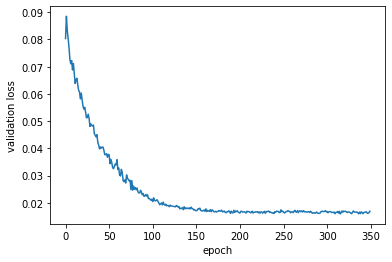

In [0]:
import matplotlib.pyplot as plt
plt.plot(range(0,350), valid_losses)
plt.xlabel('epoch')
plt.ylabel('validation loss')

37
(277, 18)


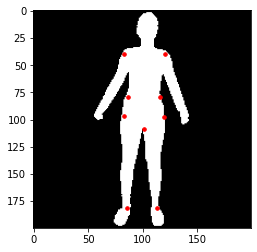

In [0]:
# Evaluate this one
model_front.load_state_dict(torch.load(ROOT_FOLDER+'model_front.pt'))
predictions_front = predict(test_loader_front, model_front)

#Show one prediction
idx = np.random.randint(predictions_front.shape[0])
print(idx)
draw_points(IMG_F_TEST[idx,:,:], predictions_front[idx,:].reshape((-1,2)))
print(predictions_front.shape)
np.save(ROOT_FOLDER+'s1155128174.npy', predictions_front)

In [0]:
# delete its output!
# Export the notebook as pdf
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!jupyter nbconvert --to PDF "./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment2/KeypointDetection_s1155128174.ipynb"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
[NbConvertApp] Converting notebook ./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment2/KeypointDetection_s1155128174.ipynb to PDF
[NbConvertApp] Support files will be in KeypointDetection_s1155128174_files/
[NbConvertApp] Making directory ./KeypointDetection_s1155128174_files
[NbConvertApp] Making directory ./KeypointDetection_s1155128174_files
[NbConvertApp] Making directory ./KeypointDetection_s1155128174_files
[NbConvertApp] Making directory ./KeypointDetection_s1155128174_files
[NbConvertApp] Making directory ./KeypointDetection_s1155128174_files
[NbConvertApp] Making di